In [1]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle 
from tqdm import tqdm   

TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic') # just so we remember which saved model is which, sizes must match

Now, our first order of business is to convert the images and labels to array information that we can pass through our network. To do this, we'll need a helper function to convert the image name to an array. 

Our images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array like so:

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

Now, we can build another function to fully process the training images and their labels into arrays:

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Now, we can run the training:

In [5]:
#train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy')

In [6]:
train_data

array([[array([[65, 68, 68, ..., 60, 56, 56],
       [72, 68, 76, ..., 62, 58, 58],
       [76, 78, 72, ..., 66, 67, 60],
       ...,
       [41, 38, 34, ..., 51, 50, 51],
       [32, 30, 36, ..., 35, 36, 41],
       [30, 27, 34, ..., 36, 38, 31]], dtype=uint8),
        array([1, 0])],
       [array([[169, 169, 168, ..., 164, 172, 167],
       [171, 171, 173, ..., 181, 170, 170],
       [171, 173, 173, ..., 178, 180, 176],
       ...,
       [100, 133, 166, ..., 167, 168, 166],
       [ 99, 125, 149, ..., 168, 168, 172],
       [118, 110, 127, ..., 168, 167, 162]], dtype=uint8),
        array([1, 0])],
       [array([[26, 26, 26, ...,  2, 13, 17],
       [26, 26, 26, ..., 15, 16,  2],
       [26, 26, 26, ...,  9, 14,  7],
       ...,
       [18, 19, 22, ..., 16, 16, 16],
       [22, 22, 22, ..., 17, 14, 14],
       [21, 23, 22, ..., 17, 16, 16]], dtype=uint8),
        array([1, 0])],
       ...,
       [array([[ 32,  71, 103, ..., 147, 148, 128],
       [195, 130,  43, ..., 144, 146, 1

# Convolutional Neural Network

Next, we're ready to define our neural network:

In [21]:
import tensorflow as tf
tf.reset_default_graph()

In [17]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

What we have here is a nice, 3layered convolutional neural network, with a fully connected layer, and then the output layer. It's been debated whether or not a fully connected layer is of any use. I'll leave it in anyway. 

This exact convnet was good enough for recognizing hand 28x28 written digits. Let's see how it does with cats and dogs at 50x50 resolution. 

Now, let's split out training and testing data:

In [18]:
train = train_data[:-500]
test = train_data[-500:]

Now, the training data and testing data are both labeled datasets. The training data is what we'll fit the neural network with, and the test data is what we're going to use to validate the results. The test data will be "out of sample," meaning the testing data will only be used to test the accuracy of the network, not to train it. 

We also have "test" images that we downloaded. THOSE images are not labeled at all, and those are what we'll submit to Kaggle for the competition.

Next, we're going to create our data arrays. For some reason, typical numpy logic like:

array[:,0] and array[:,1] did NOT work for me here. Not sure what I'm doing wrong, so I do this instead to separate my features and labels:

In [19]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

Now we fit for 3 epochs:

In [20]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.69346 | time: 68.591s
| Adam | epoch: 003 | loss: 0.69346 - acc: 0.4806 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.69351 | time: 69.771s
| Adam | epoch: 003 | loss: 0.69351 - acc: 0.4747 | val_loss: 0.69293 - val_acc: 0.5220 -- iter: 24500/24500
--


We could keep trying, but, if you haven't made accuracy progress in the first 3 epochs, you're probably not going to at all, unless it's due to overfitment...at least in my experience. 


# We're gonna need a bigger network

First, we need to reset the graph instance, since we're doing this in a continuous environment:

In [22]:
import tensorflow as tf
tf.reset_default_graph()

In [ ]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')





train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 2416  | total loss: 0.42335 | time: 22.212s
| Adam | epoch: 007 | loss: 0.42335 - acc: 0.8041 -- iter: 07552/24500


# You can be too big #

Bigger is not always better, there does get to be a limit, at least from my experience. A bigger network figures things out better, and quicker, but tends to also overfit the training data. You can use dropout (sets randomly a certain % of nodes to not take part in the network for more robusts networks) to rectify this slightly, but there does seem to be a limit. 

Okay, now what? Let's see how we've done!

# Visually inspecting our network against unlabeled data #

In [8]:
#test_data = process_test_data()

In [9]:
test_data = np.load('test_data.npy')

In [10]:
for num,data in enumerate(test_data[:12]):
    print(data[1])
    print(data[0])

4198
[[ 15  17  17 ...   3   3   3]
 [ 15  17  17 ...   3   3   3]
 [ 13  17  17 ...   3   3   2]
 ...
 [ 12  10 100 ... 172   0   7]
 [ 11  10 110 ...   9   8   9]
 [  8  24 133 ...  27  12  14]]
6038
[[ 42  53  53 ...  65  63  58]
 [ 50  53  50 ...  63  62  53]
 [ 53  58  67 ...  58  63  63]
 ...
 [102 113 117 ... 119 120 123]
 [105 109 114 ... 141 118 122]
 [115 113 105 ... 137 122 158]]
6541
[[119 198 105 ...  79 118  21]
 [122 190 117 ...  43  47  56]
 [123 194 142 ... 140  20  60]
 ...
 [171 183 179 ... 110 102  75]
 [173 176 178 ... 114 115 101]
 [166 171 171 ... 120 116 117]]
6101
[[253 253 253 ... 253 253 253]
 [253 253 253 ... 253 253 253]
 [253 253 253 ... 253 253 253]
 ...
 [253 253 253 ... 253 253 253]
 [253 253 253 ... 253 253 253]
 [253 253 253 ... 253 253 253]]
2965
[[191 191 189 ... 229 229 229]
 [192 191 190 ... 229 229 229]
 [193 192 191 ... 229 229 229]
 ...
 [  8   9 107 ... 163 178 150]
 [ 11 101 154 ... 169 155 153]
 [ 90 160 186 ... 154 133 121]]
4786
[[ 37  38 

NameError: name 'model' is not defined

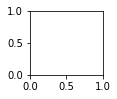

In [11]:
import matplotlib.pyplot as plt


fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    print(model.predict([data]))
    print(model.predict([data])[0])
    print(np.argmax(model_out))
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Alright, so we made a couple mistakes, but not too bad actually! 

If you're happy with it, let's compete!

In [27]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:35<00:00, 349.71it/s]
